# Fentanyl Random Forest Classification Model
Predicting Fentanyl overdoses based on darknet data


# Quantity extraction function

In [6]:
def drugTimeSeries(listingTitles,dates,prices):

    import numpy as np
    import pylab as plt
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import io
    import os
    from shutil import copyfile
    from datetime import datetime
    import datetime as dtime

    from quantulum import parser # Quantulum - Extract quantities from unstructured text
    from pint import UnitRegistry # Pint - Physical quantities module
    ureg = UnitRegistry()
    
     ## add custom unit descriptor file to Quantulum package
    source_file = os.getcwd() + '/units.json'
    if os.path.exists(source_file):
        dest_file =  os.path.dirname(parser.__file__) + '/units.json'
        if os.path.exists(dest_file):
            copyfile(source_file, dest_file)
            print "Custom units.json file copied to Quantulum folder"


    ## Get parsed quantity information
    quants = []

    for ii, l in enumerate(listingTitles.values.tolist()):
        # fix some exceptions that otherwise would break the parser
        l = unicode(l)

        # Some vendors don't leave spaces, so let's fix that
        l = l.replace('half grams', '0.5 grams ', 1) # 1 space after
        l = l.replace('Grams', 'Grams ', 1) # 1 space after
        l = l.replace('g$', 'g,$', 1)       # separate g and $

        try:
            parsed_quantities = parser.parse(l)
        except:
            # something went wrong
            try:
                # fix some exceptions that otherwise would break the parser
                l=l.replace("/"," / ")
                l=l.replace("-","_")
                # and try again
                parsed_quantities = parser.parse(l)
            except:
                try:
                    # fix some other exceptions that otherwise would break the parser
                    l = l.lower()
                    l=l.replace(" to "," __ ")
                    parsed_quantities = parser.parse(l)
                except:
                    print "Oh no! Parser failed when parsing", l
                    parsed_quantities = []

        quants.append(parsed_quantities) #create list with parsed data

    #quants = parser.parse('15x 1000ug Fentanyl blotters') # for single line testing

    ## Create arrays

    #lName = np.array(listingTitles.values.tolist(), dtype=object) # listing names

    dt = np.dtype([('mass', np.float64)])
    npMassInGrams = np.empty_like(listingTitles.values.tolist(), dtype=dt) # mass of the drug

    dt = np.dtype([('count', np.float64)])
    npNumGoods = np.empty_like(listingTitles.values.tolist(), dtype=dt) # number of goods available

    dt = np.dtype([('date', np.str_, 32)])
    npDates = np.empty_like(listingTitles.values.tolist(), dtype=dt) # number of goods available

    dt = np.dtype([('price', np.str_, 32)])
    npPrices = np.empty_like(listingTitles.values.tolist(), dtype=dt) # number of goods available

    # print len(listingTitles)
    # print len(quants)
    # print len(npMassInGrams)

    ## Get mass of goods

    for ii, parsedTitle in enumerate(quants):
        #print parsedTitle
        for q in parsedTitle:
            quantity = abs(q.value)
            unit = q.unit.name
            entity = q.unit.entity.name
            # check if entity is a mass
            if entity == "mass":
                quantity_in_any_unit = quantity * ureg.parse_expression(q.unit.name)
                quantity_in_gram = quantity_in_any_unit.to('gram')
                npMassInGrams['mass'][ii] = quantity_in_gram.magnitude
                break # only consider the first mass in case there are multiples
            else:
                npMassInGrams['mass'][ii] = np.nan
                #print q.value, q.unit.name, "is not at mass"

    ## Plot histogram

    masses = npMassInGrams['mass'][~np.isnan(npMassInGrams['mass'])];

    n, bins, patches = plt.hist(masses, bins=(1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5),
                                normed=0, facecolor='green', alpha=0.5, label="Product mass")

#     fig = plt.figure(1)
#     fig.suptitle('Fentanyl darknet market distribution', fontsize=15)
#     plt.xlabel("Product mass (g)",fontsize=15)
#     plt.ylabel("Number of listings",fontsize=15)
#     #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#     #plt.xlim([0.1,max(masses)])
#     plt.grid(True)
#     plt.legend(shadow=True, fancybox=True)
#     plt.xscale('log')
#     plt.show()
#     fig.savefig(sstr+'.png')

#     ## save to CSV files

#     (pd.Series(masses)).to_csv(sstr+'_Fentanyl_massesInGrams.csv',index=False, header=["masses"])
#     dates.to_csv(sstr+'_Fentanyl_dates.csv',index=False,header=["dates"])
#     prices.to_csv(sstr+'_Fentanyl_prices.csv',index=False,header=['prices'])

## Fentanyl price and number of listings

    massLow = 0.01 #10 mg
    massHigh = 1 # 1g

    ## select Fentanyl for private consumption

#     dates = pd.read_csv(sstr+'_Fentanyl_dates.csv')
#     prices = pd.read_csv(sstr+'_Fentanyl_prices.csv')
#     masses = pd.read_csv(sstr+'_Fentanyl_massesInGrams.csv')
    BTC_USD_rate = pd.read_csv('bitcoin_dollar_rate.csv') # BTC course for every single day
    
    # --- second part ---
    
    df_dates = pd.DataFrame({'dates':dates})
    df_masses = pd.DataFrame({'masses':masses})
    df_prices = pd.DataFrame({'prices':prices})
    
    # match to dates in dataset
    r = []
    for d in df_dates['dates']:
        idx = BTC_USD_rate['Date'].values == d
        r.append( BTC_USD_rate['Close'].values[idx] )
    df_rate = pd.DataFrame(r, columns=['BTC_USD_rate'])

    # combine in pandas array
    df = pd.concat([df_dates, df_prices, df_rate, df_masses], axis=1)

    df_massSelections = []
    # select only masses within desired range
    df_massSelections.append( df[ (df['masses']>1e-12) & (df['masses'] <= massLow) ] )
    df_massSelections.append( df[ (df['masses']>massLow) & (df['masses'] <= massHigh) ] )
    df_massSelections.append( df[ (df['masses']>massHigh) ] )

    iFentanylDataAllMasses = []
    iFentanylDataMassIndex = []
    for idxMassSel, df_massSel in enumerate(df_massSelections):
        if len(df_massSel['masses']) > 0: # only do something if there are listings for this mass

            x = []
            for date in df_massSel['dates'].values:
                x.append(datetime.strptime(date, "%Y-%m-%d"))

            y = []
            for ii, price in enumerate(df_massSel['prices'].values):
                pBTC = float(price.replace("BTC ",""))
                pUSD = pBTC*df_massSel['BTC_USD_rate'].values[ii]
                m = df_massSel['masses'].values[ii]
                if pUSD > 1e5: # fix three errors in the dataset
                    pUSD = 0
                pricePerGram = pUSD/m
                if pricePerGram > 1e6: # fix three errors in the dataset
                    pricePerGram = 0
                y.append( pricePerGram )

            # average prices on the same date
            yAvgPrice = []
            yNumListings = []
            unique_dates = df_massSel['dates'].unique()
            for ud in unique_dates:
                idx = df_massSel['dates'].values == ud
                allPricesOfThatDay = pd.Series(y)[idx]
                yAvgPrice.append( allPricesOfThatDay.mean(axis=0) )
                yNumListings.append( len(allPricesOfThatDay)-1)

            xUniqueDates = []
            for date in unique_dates:
                xUniqueDates.append(datetime.strptime(date, "%Y-%m-%d"))

            # ----------------------
            FenData = pd.DataFrame({'dates' : xUniqueDates,
                                    'avgPrice' : yAvgPrice,
                                    'numListings' : yNumListings})

            ## interpolate data for every day

            print len(FenData["dates"])
            lastDate = FenData["dates"][len(FenData["dates"])-1]
            dateRange = lastDate - FenData["dates"][0] 

            idx = [] #index of original dates
            dr = (FenData["dates"] - FenData["dates"][0])
            for d in dr:
                idx.append( d.days )

            firstDate = dtime.datetime(2014, 3, 1)
                
            iDates = [] # every day array
            iidxDates = [] # index of every day array
            for ii in range(0,400):
                iDates.append( firstDate + dtime.timedelta(ii) )
                iidxDates.append(ii)

            iNumListings = pd.Series ( np.interp(iidxDates, idx, FenData["numListings"]).tolist() , index = iDates)
            iAvgPrice = pd.Series ( np.interp(iidxDates, idx, FenData["avgPrice"]).tolist(), index = iDates)

            # smoothing
            smoothWindowWidth = 30
            iNumListingsSmooth=iNumListings.rolling(smoothWindowWidth,center=True).sum()
            iAvgPriceSmooth=iAvgPrice.rolling(smoothWindowWidth,center=True).sum()

            # data saving
            iFentanylData = pd.DataFrame({'avgPrice' : iAvgPrice,'numListings' : iNumListings})

            iFentanylDataAllMasses.append(iFentanylData)
            iFentanylDataMassIndex.append(idxMassSel)
            
#             # save Fentanyl data to CSV files
#             fname = sstr+"Fentanyl_date_price_numListings_massGroup="+str(idxMassSel)\
#             +"_MLow="+ str(massLow)+"g_MHigh="+str(massHigh)+"g"+".csv"

#             iFentanylData.to_csv('./features/'+fname)

            fig = plt.figure()
            try:
                iNumListingsSmooth.plot()
            except:
                print 'plotting error'
            fig = plt.figure()
            try:
                iAvgPriceSmooth.plot()
            except:
                print 'plotting error 2'
    
    # after cycling through all masses
    return iFentanylDataAllMasses, iFentanylDataMassIndex
                    


    # outlier
    # 46756 2014-06-19 evolution/2014-06-19/listing/22819/feedback
    # 1.0 Gram of Excellent 4 China White Heroin - United States - TheMagician - BTC 175.0000

# Load listing from SQL

fentanyl
0    1 x 75mcg Fentanyl Patch 1734mg from 1A Pharma...
1    1 x 100g/h Fentanyl Matrix Patch containing 23...
2              1X 50 mg/hr Fentanyl Transdermal System
3    1 x 75mcg Fentanyl Patch 1734mg from 1A Pharma...
4    1 x 100g/h Fentanyl Matrix Patch containing 23...
Name: product, dtype: object
Custom units.json file copied to Quantulum folder
82
81
65


acetylfentanyl
0      500g Acetylfentanyl Powder (99%+ Pure)
1     1000g Acetylfentanyl Powder (99%+ Pure)
2      100g Acetylfentanyl Powder (99%+ Pure)
3       10g Acetylfentanyl Powder (99%+ Pure)
4    1000mg Acetylfentanyl Powder (99%+ Pure)
Name: product, dtype: object
Custom units.json file copied to Quantulum folder
8
4


acetyl fentanyl
0    250 mg Acetyl Fentanyl Shipped from USA
1       1 g Acetyl Fentanyl Shipped from USA
2    250 mg Acetyl Fentanyl Shipped from USA
3       1 g Acetyl Fentanyl Shipped from USA
4    250 mg Acetyl Fentanyl Shipped from USA
Name: product, dtype: object
Custom units.json file cop

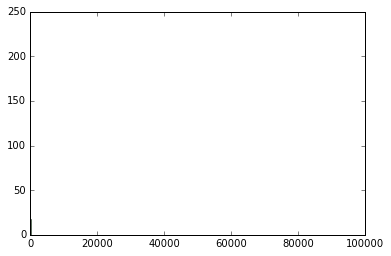

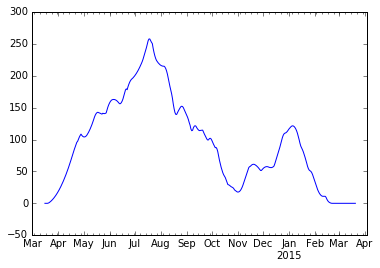

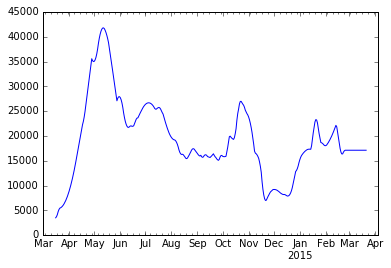

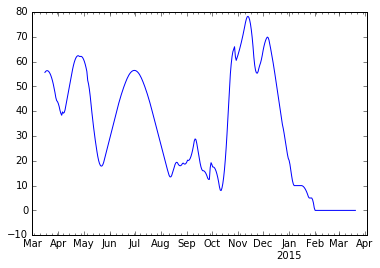

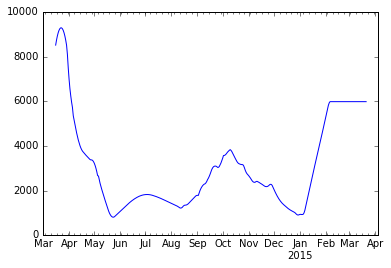

In [7]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import pandas as pd
import pymysql as mdb
import numpy as np


FentanylDict = pd.read_csv('FentanylDictionary.csv')
#FentanylDict.head()

## find Fentanyl listingTitles

con = None
con = mdb.connect('localhost', 'userX', 'qwerty', 'evolution_db') #host, user, password, #database

column = 'product'

## creat search string for SQL query
searchStringsList = FentanylDict['Synonym'].tolist();
searchStrings = []
searchStringsList = FentanylDict['Synonym'].tolist();
for sstr in searchStringsList:
    for s in sstr.split(','):
        if len(s) > 1:
            searchStrings.append(s)

df_searchStrings = pd.DataFrame({'synonym' : searchStrings})
searchStringsUnique = df_searchStrings['synonym'].str.lower().unique()

# prepare model arrays
X = (pd.DataFrame({'dayIndex' : range(0,400)})).as_matrix()
Xlabel = ['dayIndex']
Xmass = ['']
Xdrugname = ['']
massHeaders = ['Private cons. (<=10mg)','Dealer (>10mg, <=1g)','Distributor (>1g)']
datatypeHeaders = ['Avg. price', '# Listings']
# iFentanylData: always: 'avgPrice', 'listings'


for sstr in searchStringsUnique:
    searchStr = 'WHERE ('
    searchStr = searchStr + "%s LIKE '%% %s %%' " % (column, sstr)
    searchStr = searchStr + ')'

    sql_query = """
    SELECT *
    FROM listings
    %s;
    """ % (searchStr)
#     LIMIT 5 OFFSET 0

    listings = pd.read_sql_query(sql_query,con)
    listingTitles = listings['product']
    dates = listings['date']
    prices = listings['price']
    
    if not listingTitles.empty:
        print sstr
        print listingTitles.head()
        iFentanylDataAllMasses, iFentanylDataMassIndex = drugTimeSeries(listingTitles,dates,prices)
        print
        print
        
        # put together features X for model
        if iFentanylDataAllMasses:
            for ii, iFD in enumerate(iFentanylDataAllMasses):
                X = np.concatenate( (X,iFD.as_matrix()),axis=1)
                # append each twice, since there are two columns each data packet
                Xlabel.append(datatypeHeaders[0]+' for '+sstr+', '+massHeaders[ iFentanylDataMassIndex[ii] ])
                Xlabel.append(datatypeHeaders[1]+' for '+sstr+', '+massHeaders[ iFentanylDataMassIndex[ii] ])
                Xmass.append(massHeaders[ iFentanylDataMassIndex[ii] ])
                Xmass.append(massHeaders[ iFentanylDataMassIndex[ii] ])
                Xdrugname.append(sstr)
                Xdrugname.append(sstr)
            
X_withDate = X
Xlabel_withDate=Xlabel
Xmass_withDate=Xmass
Xdrugname_withDate=Xdrugname

In [5]:
## look at what we got: oh, 33 features!
col = 32
print Xlabel[col]
print Xmass[col]
print Xdrugname[col]
print X[:,col]

# Listings for china white, Distributor (>1g)
Distributor (>1g)
china white
[ 1.          1.08333333  1.16666667  1.25        1.33333333  1.41666667
  1.5         1.58333333  1.66666667  1.75        1.83333333  1.91666667
  2.          1.5         1.          1.66666667  2.33333333  3.          2.88
  2.76        2.64        2.52        2.4         2.28        2.16        2.04
  1.92        1.8         1.68        1.56        1.44        1.32        1.2
  1.08        0.96        0.84        0.72        0.6         0.48        0.36
  0.24        0.12        0.          0.28571429  0.57142857  0.85714286
  1.14285714  1.42857143  1.71428571  2.          4.          2.
  2.66666667  3.33333333  4.          3.875       3.75        3.625       3.5
  3.375       3.25        3.125       3.          2.625       2.25        1.875
  1.5         1.125       0.75        0.375       0.          0.04444444
  0.08888889  0.13333333  0.17777778  0.22222222  0.26666667  0.31111111
  0.35555556  0.4    

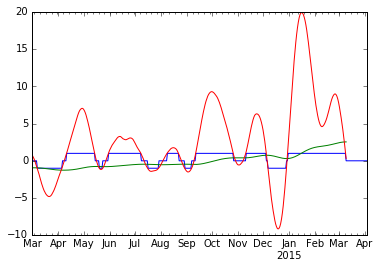

In [8]:
## now get Y for the model
import pandas as pd
import numpy as np
import pylab as plt
import datetime as dt
import math
%matplotlib inline

numberOfGNhits = pd.read_csv("./features/Y/fentanylANDdeathORoverdose_2014_01_01_to_2015_04_015.csv")

datesNumHits=[]
numberOfHits = []
fig = plt.figure()
for hit in numberOfGNhits['date']:
    datesNumHits.append (dt.datetime.strptime(hit,"%Y-%m-%d"))

numHitsList = []
for hit in numberOfGNhits['numHits']:
    hit=hit.replace('[','')
    hit=hit.replace(']','')
    numHitsList.append( int(hit) )
    
df_hits=pd.Series(numHitsList, index = datesNumHits)

smoothWindowWidth = 20
df_hitsSmooth=df_hits.rolling(smoothWindowWidth,center=True).sum()
df_hitsSmooth=df_hitsSmooth.rolling(smoothWindowWidth,center=True).mean()
df_hitsSmooth=df_hitsSmooth.rolling(smoothWindowWidth,center=True).mean()
df_hitsSmooth=df_hitsSmooth.rolling(smoothWindowWidth,center=True).mean()


# convert to raising/falling/constant time series
hitsConstantDetectrange = 1
hitsUpDown = []
for gradHit in df_hitsSmooth.diff():
    if math.isnan(gradHit):
        hitsUpDown.append(0)
    elif gradHit>=hitsConstantDetectrange:
        hitsUpDown.append(1)
    elif gradHit<=-hitsConstantDetectrange:
        hitsUpDown.append(-1)
    else:
        hitsUpDown.append(0)

df_hitsUpDown=pd.Series(hitsUpDown, index = datesNumHits)

# fig = plt.figure()
# df_hitsSmooth.plot()
# fig = plt.figure()
# df_hitsUpDown.plot()


firstDate = dt.datetime(2014, 3, 1)
fullDateRange = 400

ig = plt.figure()
#digital classified
df_hitsUpDown400 = df_hitsUpDown[firstDate:firstDate+dt.timedelta(fullDateRange-1)]
df_hitsUpDown400.plot()
# linear
df_hitsSmooth400 = df_hitsSmooth[firstDate:firstDate+dt.timedelta(fullDateRange-1)]
((df_hitsSmooth400-df_hitsSmooth400.mean())/df_hitsSmooth400.std()).plot()
# derivative
df_hitsSmooth400diff = df_hitsSmooth.diff()[firstDate:firstDate+dt.timedelta(fullDateRange-1)]
df_hitsSmooth400diff.plot()

yDiff = df_hitsSmooth400diff.as_matrix()
yLinear = df_hitsSmooth400.as_matrix()
y = df_hitsUpDown400.as_matrix()
dvx = []
for dv in df_hitsSmooth400.index:
    dvx.append( np.datetime64(dv) )
dateVector = np.array(dvx)

## Model juhuuiii



In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

# --- remove date column ---
X = np.delete(X_withDate,0,1)
Xlabel = Xlabel_withDate[1:]
Xmass = Xmass_withDate[1:]
Xdrugname = Xdrugname_withDate[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=123)

# Create Random Forest object
model= RandomForestClassifier(n_estimators=200)
# Train the model using the training sets and check score
model.fit(X_train,y_train)
# Predict Output
y_predicted = model.predict(X_test)

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=4, test_size=0.25, random_state=777)
crossValScore = cross_validation.cross_val_score(model, X, y, cv=cv)

p1 = float(sum(y_train == 1))/len(y_train)*100
p0 = float(sum(y_train == 0))/len(y_train)*100
p_1 = float(sum(y_train == -1))/len(y_train)*100
print 'Imbalanced model'
print 'Class balance: %d%% / %d%% / %d%%' % (p1,p0,p_1)
print 'Training/Test Ratio: '+str(X_train.shape[0] / X_test.shape[0])
print 'Classifier score='+str(model.score(X_test, y_test))
print 'Cross-validation score='+str(crossValScore)
pd.crosstab(y_test, y_predicted, rownames=['actual'], colnames=['preds'])

Imbalanced model
Class balance: 56% / 24% / 19%
Training/Test Ratio: 3
Classifier score=0.808080808081
Cross-validation score=[ 0.88  0.86  0.83  0.9 ]


preds,-1,0,1
actual,,,
-1,13,3,3
0,4,18,2
1,0,7,49


In [10]:
## Fix class imbalance
from unbalanced_dataset.over_sampling import RandomOverSampler
from unbalanced_dataset.over_sampling import SMOTE #Synthetic Minority Over-sampling Technique
# 'SMOTE'
smote = SMOTE(ratio='auto', verbose=False, kind='regular')
SMO_X_train_temp, SMO_y_train_temp = smote.fit_transform(X_train, y_train)
SMO_X_train, SMO_y_train = smote.fit_transform(SMO_X_train_temp, SMO_y_train_temp)

# Create Random Forest object
model= RandomForestClassifier(n_estimators=200)
# Train the model using the training sets and check score
model.fit(SMO_X_train,SMO_y_train)
# Predict Output
y_predicted = model.predict(X_test)

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=4, test_size=0.25, random_state=777)
crossValScore = cross_validation.cross_val_score(model, X, y, cv=cv)

p1 = float(sum(SMO_y_train == 1))/len(SMO_y_train)*100
p0 = float(sum(SMO_y_train == 0))/len(SMO_y_train)*100
p_1 = float(sum(SMO_y_train == -1))/len(SMO_y_train)*100
print 'Balanced model'
print 'Class balance: %d%% / %d%% / %d%%' % (p1,p0,p_1)
print 'Training/Test Ratio: '+str(X_train.shape[0] / X_test.shape[0])
print 'Classifier score='+str(model.score(X_test, y_test))
print 'Cross-validation score='+str(crossValScore)
pd.crosstab(y_test, y_predicted, rownames=['actual'], colnames=['preds'])

Balanced model
Class balance: 33% / 33% / 33%
Training/Test Ratio: 3
Classifier score=0.787878787879
Cross-validation score=[ 0.89  0.87  0.82  0.9 ]


preds,-1,0,1
actual,,,
-1,13,3,3
0,4,18,2
1,1,8,47


Confusion matrix, without normalization
[[13  3  3]
 [ 4 18  2]
 [ 1  8 47]]
             precision    recall  f1-score   support

         -1       0.72      0.68      0.70        19
          0       0.62      0.75      0.68        24
          1       0.90      0.84      0.87        56

avg / total       0.80      0.79      0.79        99

Normalized confusion matrix
[[ 0.68  0.16  0.16]
 [ 0.17  0.75  0.08]
 [ 0.02  0.14  0.84]]


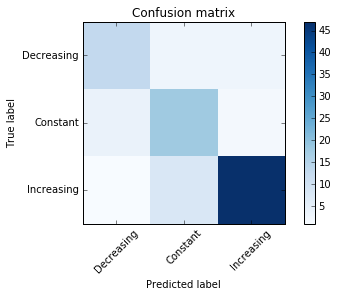

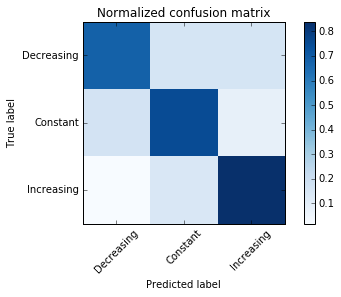

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = [0,1,2]
    plt.xticks(tick_marks, ['Decreasing', 'Constant', 'Increasing'], rotation=45)
    plt.yticks(tick_marks, ['Decreasing', 'Constant', 'Increasing'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_test, y_predicted)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
print classification_report(y_test, y_predicted)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

[ 16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5
  28.5  29.5  30.5]
[ 44.38  46.93  51.12  53.28  53.79  55.97  61.81  62.44  70.65  79.77]


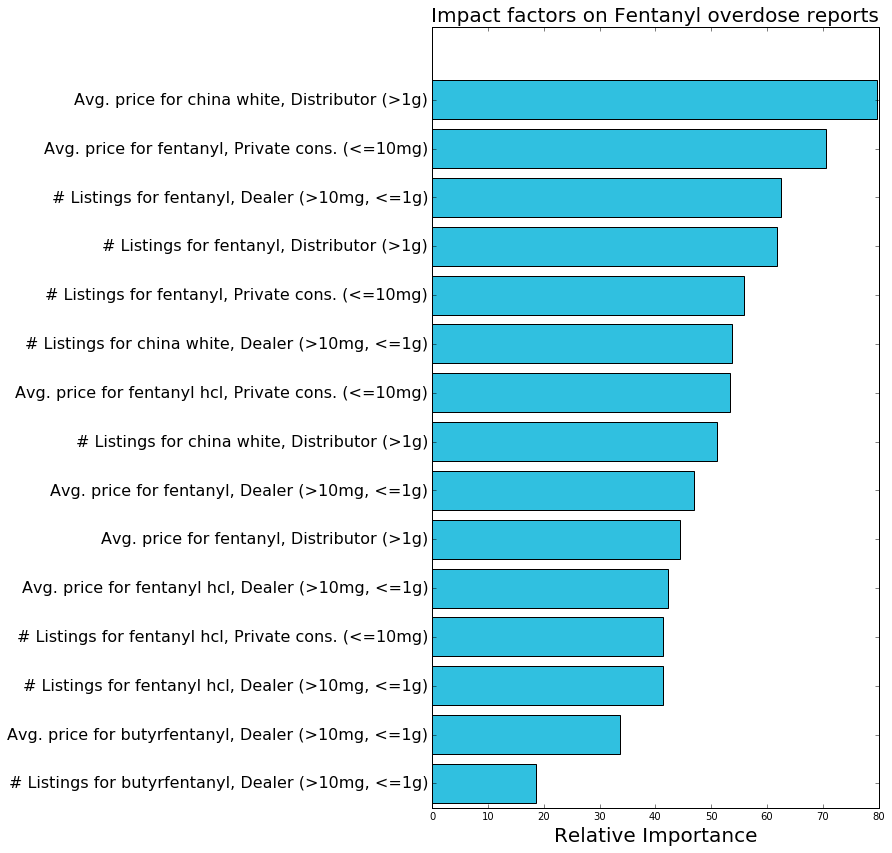

In [12]:
numBars = 15
# Get Feature Importance from the classifier
feature_importance = model.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
print pos[len(pos)-numBars-1:-1]
print feature_importance[sorted_idx][len(pos)-11:-1]
plt.figure(figsize=(8, 14))
plt.barh(pos[len(pos)-numBars-1:-1], feature_importance[sorted_idx][len(pos)-numBars-1:-1], align='center', color='#30C0E0')
plt.yticks(pos[len(pos)-numBars-1:-1], np.asanyarray(Xlabel)[sorted_idx][len(pos)-numBars-1:-1],fontsize = 16)
plt.xlabel('Relative Importance',fontsize = 20)
plt.title('Impact factors on Fentanyl overdose reports',fontsize = 20)
plt.show()

## Pickle it

In [13]:
np.save('Fentanyl_Feature_X', X)
np.save('Fentanyl_Output_y', y)
np.save('Fentanyl_Output_yDiff', yDiff)
np.save('Fentanyl_Output_yLinear', yLinear)
np.save('Fentanyl_Xlabel', Xlabel)
np.save('Fentanyl_dateVector', dateVector)

import pickle
with open('DNetModel.b', 'wb') as modelfile:
    pickle.dump(model, modelfile)